In [1]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.data.medical_imaging import get_chexpert
from source.utils.metrics import auroc, aod, eod, spd

os.makedirs(PLOTS_PATH, exist_ok=True)

/system/apps/userenv/kschweig/quam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
method_seeds = [42, 142, 242, 342, 442]
dseed = 42

model = ["resnet18", "resnet34", "resnet50"][2]

pas = ["old", "woman", "white"]
pa = 0 # 0, 1, 2

n_samples = 2_000

In [3]:
full_ds, _, _ = get_chexpert(load_to_ram=False)

run_path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{method_seeds[0]}_dseed{dseed}")
fair_inds = torch.load(os.path.join(run_path, "fair_inds.pt"))
val_inds = torch.load(os.path.join(run_path, "val_inds.pt"))

print(len(fair_inds), len(val_inds))

y_fair_t = full_ds.targets[fair_inds]
a_fair_t = full_ds.protected_attributes[pa, fair_inds]
y_val_t = full_ds.targets[val_inds]
a_val_t = full_ds.protected_attributes[pa, val_inds]

# switch 0 / 1 in protected attribute
pas = ["young", "man", "non-white"]
a_fair_t = 1 - a_fair_t
a_val_t = 1 - a_val_t

p_a_fair = a_fair_t.float().mean().item() * 100

# patients general 65401
# patients with race 58010
24638 24638


In [4]:
# load probits
fair_probits, val_probits = list(), list()
for mseed in method_seeds:
    path = os.path.join(RESULTS_PATH, f"chexpert_{model}_mseed{mseed}_dseed{dseed}")

    # don't do fairness ensemble on medical imaging - use this split as test dataset
    fair_probits.append(torch.load(os.path.join(path, f"fair_probits.pt")))
    val_probits.append(torch.load(os.path.join(path, f"val_probits.pt")))

In [5]:
# calculate accuracies and fairness measures
fair_aurocs, val_aurocs = list(), list()
fair_spds, val_spds = list(), list()
fair_eods, val_eods = list(), list()
fair_aods, val_aods = list(), list()

for m in range(len(method_seeds)):
    fair_aurocs.append([auroc(p[:, 1], y_fair_t) for p in fair_probits[m]])
    val_aurocs.append([auroc(p[:, 1], y_val_t) for p in val_probits[m]])

    fair_spds.append([spd(p.argmax(dim=1), a_fair_t) for p in fair_probits[m]])
    val_spds.append([spd(p.argmax(dim=1), a_val_t) for p in val_probits[m]])

    fair_eods.append([eod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_eods.append([eod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])

    fair_aods.append([aod(p.argmax(dim=1), y_fair_t, a_fair_t) for p in fair_probits[m]])
    val_aods.append([aod(p.argmax(dim=1), y_val_t, a_val_t) for p in val_probits[m]])

In [6]:
fair_m_aurocs, fair_rm_aurocs = list(), list()
fair_m_spds, fair_rm_spds = list(), list()
fair_m_eods, fair_rm_eods = list(), list()
fair_m_aods, fair_rm_aods = list(), list()

rng = np.random.default_rng(seed=42)

samples = list()

for m in range(len(method_seeds)):
    fair_m_aurocs.append(auroc(torch.mean(fair_probits[m], dim=0)[:, 1], y_fair_t))
    fair_m_spds.append(spd(torch.mean(fair_probits[m], dim=0).argmax(dim=1), a_fair_t))
    fair_m_eods.append(eod(torch.mean(fair_probits[m], dim=0).argmax(dim=1), y_fair_t, a_fair_t))
    fair_m_aods.append(aod(torch.mean(fair_probits[m], dim=0).argmax(dim=1), y_fair_t, a_fair_t))

    fair_rm_aurocs_, fair_rm_spds_, fair_rm_eods_, fair_rm_aods_ = list(), list(), list(), list()
    for i in range(n_samples):
        
        # include individual models
        if i < len(fair_probits[0]):
            sample = torch.zeros(len(fair_probits[0]), 1, 1)
            sample[i] = 1
        # sample uniform from simplex
        else:
            sample = torch.as_tensor(rng.dirichlet(np.ones(len(fair_probits[0])))).reshape(-1, 1, 1)
        samples.append(sample)

        fair_rm_aurocs_.append(auroc(torch.sum((fair_probits[m] * sample), dim=0)[:, 1], y_fair_t))
        fair_rm_spds_.append(spd(torch.sum((fair_probits[m] * sample), dim=0).argmax(dim=1), a_fair_t))
        fair_rm_eods_.append(eod(torch.sum((fair_probits[m] * sample), dim=0).argmax(dim=1), y_fair_t, a_fair_t))
        fair_rm_aods_.append(aod(torch.sum((fair_probits[m] * sample), dim=0).argmax(dim=1), y_fair_t, a_fair_t))

    fair_rm_aurocs.append(fair_rm_aurocs_)
    fair_rm_spds.append(fair_rm_spds_)
    fair_rm_eods.append(fair_rm_eods_)
    fair_rm_aods.append(fair_rm_aods_)

fair_rm_aurocs = np.array(fair_rm_aurocs)
fair_rm_spds = np.array(fair_rm_spds)
fair_rm_eods = np.array(fair_rm_eods)
fair_rm_aods = np.array(fair_rm_aods)

In [7]:
from scipy.spatial import ConvexHull

def get_convex_hull_points(points):
    hull = ConvexHull(points)

    x_points = points[hull.vertices, 0].tolist()
    x_points.append(points[hull.vertices[0], 0])
    y_points = points[hull.vertices, 1].tolist()
    y_points.append(points[hull.vertices[0], 1])

    return x_points, y_points   

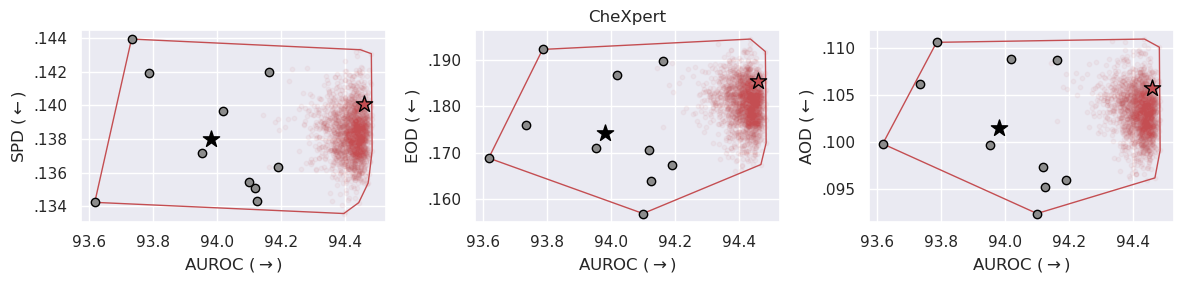

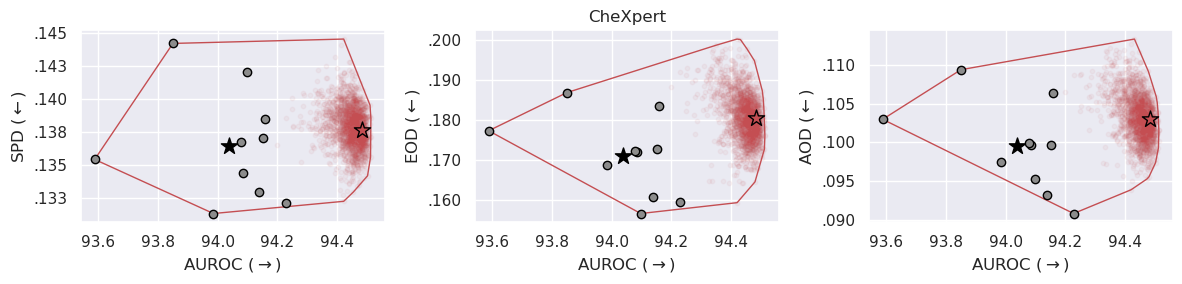

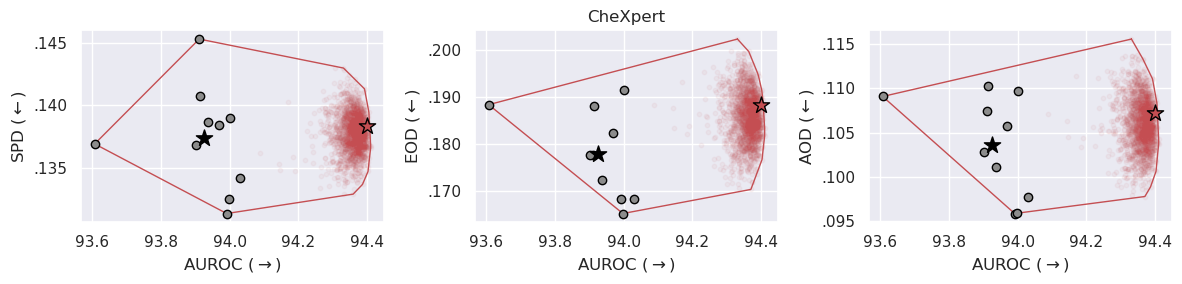

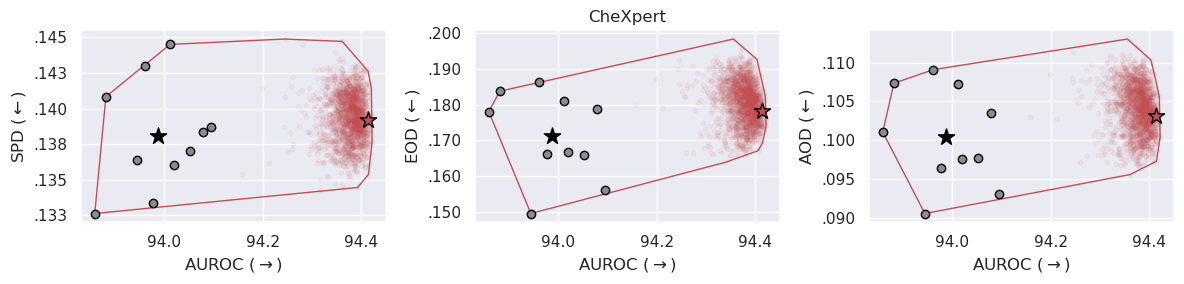

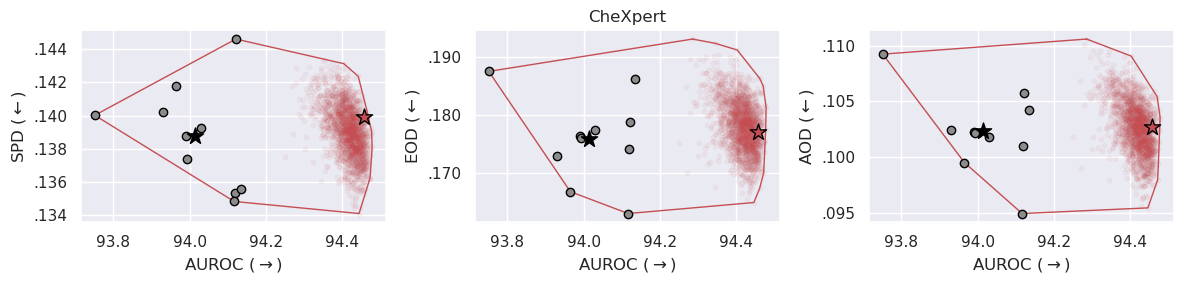

In [8]:
for m, mseed in enumerate(method_seeds):
    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].scatter(fair_aurocs[m], fair_spds[m], color="C7", edgecolors="black", zorder=99)
    axs[0].scatter(np.mean(fair_aurocs[m]), np.mean(fair_spds[m]), marker="*", c="black", s=150, zorder=99)
    axs[0].scatter(fair_m_aurocs[m], fair_m_spds[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[0].scatter(fair_rm_aurocs[m], fair_rm_spds[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((fair_rm_aurocs[m].flatten(), fair_rm_spds[m].flatten())))
    axs[0].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[0].set_ylabel("SPD ($\\leftarrow$)")
    axs[1].scatter(fair_aurocs[m], fair_eods[m], color="C7", edgecolors="black", zorder=99)
    axs[1].scatter(np.mean(fair_aurocs[m]), np.mean(fair_eods[m]), marker="*", c="black", s=150, zorder=99)
    axs[1].scatter(fair_m_aurocs[m], fair_m_eods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[1].scatter(fair_rm_aurocs[m], fair_rm_eods[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((fair_rm_aurocs[m].flatten(), fair_rm_eods[m].flatten())))
    axs[1].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[1].set_ylabel("EOD ($\\leftarrow$)")
    axs[2].scatter(fair_aurocs[m], fair_aods[m], color="C7", edgecolors="black", zorder=99)
    axs[2].scatter(np.mean(fair_aurocs[m]), np.mean(fair_aods[m]), marker="*", c="black", s=150, zorder=99)
    axs[2].scatter(fair_m_aurocs[m], fair_m_aods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[2].scatter(fair_rm_aurocs[m], fair_rm_aods[m], c="C3", s=10, alpha=0.05)
    x_points, y_points = get_convex_hull_points(np.column_stack((fair_rm_aurocs[m].flatten(), fair_rm_aods[m].flatten())))
    axs[2].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[2].set_ylabel("AOD ($\\leftarrow$)")

    axs[1].set_title("CheXpert")

    for ax in axs.flatten():
        ax.set_xlabel("AUROC ($\\rightarrow$)")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))

    f.tight_layout()
    if m == 0:
        f.savefig(os.path.join(PLOTS_PATH, f"medical_imaging_{model}_{pa}_convex_hull.png"), dpi=300)
    plt.show()

In [9]:
val_m_aurocs, val_rm_aurocs = list(), list()
val_m_spds, val_rm_spds = list(), list()
val_m_eods, val_rm_eods = list(), list()
val_m_aods, val_rm_aods = list(), list()

for m in range(len(method_seeds)):
    val_m_aurocs.append(auroc(torch.mean(val_probits[m], dim=0)[:, 1], y_val_t))
    val_m_spds.append(spd(torch.mean(val_probits[m], dim=0).argmax(dim=1), a_val_t))
    val_m_eods.append(eod(torch.mean(val_probits[m], dim=0).argmax(dim=1), y_val_t, a_val_t))
    val_m_aods.append(aod(torch.mean(val_probits[m], dim=0).argmax(dim=1), y_val_t, a_val_t))

    val_rm_aurocs_, val_rm_spds_, val_rm_eods_, val_rm_aods_ = list(), list(), list(), list()
    for i in range(n_samples):
        
        sample = samples[i]

        val_rm_aurocs_.append(auroc(torch.sum((val_probits[m] * sample), dim=0)[:, 1], y_val_t))
        val_rm_spds_.append(spd(torch.sum((val_probits[m] * sample), dim=0).argmax(dim=1), a_val_t))
        val_rm_eods_.append(eod(torch.sum((val_probits[m] * sample), dim=0).argmax(dim=1), y_val_t, a_val_t))
        val_rm_aods_.append(aod(torch.sum((val_probits[m] * sample), dim=0).argmax(dim=1), y_val_t, a_val_t))

    val_rm_aurocs.append(val_rm_aurocs_)
    val_rm_spds.append(val_rm_spds_)
    val_rm_eods.append(val_rm_eods_)
    val_rm_aods.append(val_rm_aods_)

val_rm_aurocs = np.array(val_rm_aurocs)
val_rm_spds = np.array(val_rm_spds)
val_rm_eods = np.array(val_rm_eods)
val_rm_aods = np.array(val_rm_aods)

In [44]:
import numpy as np
# Convert the lists to numpy arrays
val_rm_aurocs = np.array(val_rm_aurocs)
val_rm_spds = np.array(val_rm_spds)
val_rm_eods = np.array(val_rm_eods)
val_rm_aods = np.array(val_rm_aods)

# Calculate the rankings
aurocs_ranking = np.argsort(val_rm_aurocs)[:, ::-1]
spds_ranking = np.argsort(np.abs(val_rm_spds))
eods_ranking = np.argsort(np.abs(val_rm_eods))
aods_ranking = np.argsort(np.abs(val_rm_aods))

average_rank = aurocs_ranking + spds_ranking
spd_avg_rank_index = np.take_along_axis(aurocs_ranking, 
                                        np.argmax(average_rank, axis=1, keepdims=True).reshape(-1, 1), 
                                        axis=1).flatten()

average_rank = aurocs_ranking + eods_ranking
eods_avg_rank_index = np.take_along_axis(aurocs_ranking,
                                        np.argmax(average_rank, axis=1, keepdims=True).reshape(-1, 1), 
                                        axis=1).flatten()

average_rank = aurocs_ranking + aods_ranking
aods_avg_rank_index = np.take_along_axis(aurocs_ranking,
                                        np.argmax(average_rank, axis=1, keepdims=True).reshape(-1, 1), 
                                        axis=1).flatten()


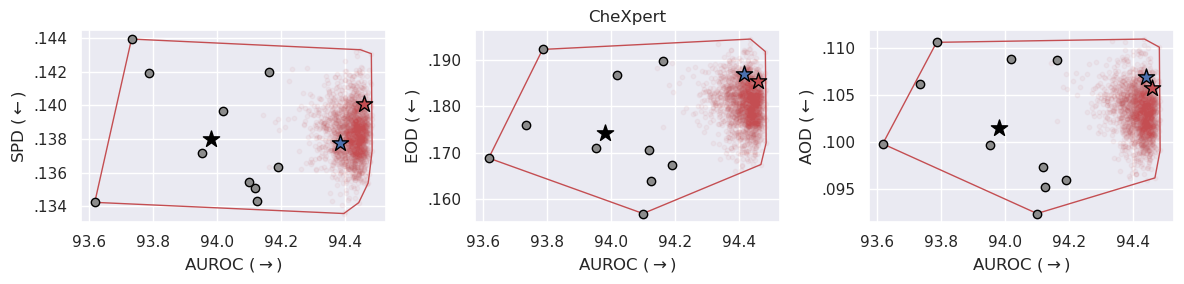

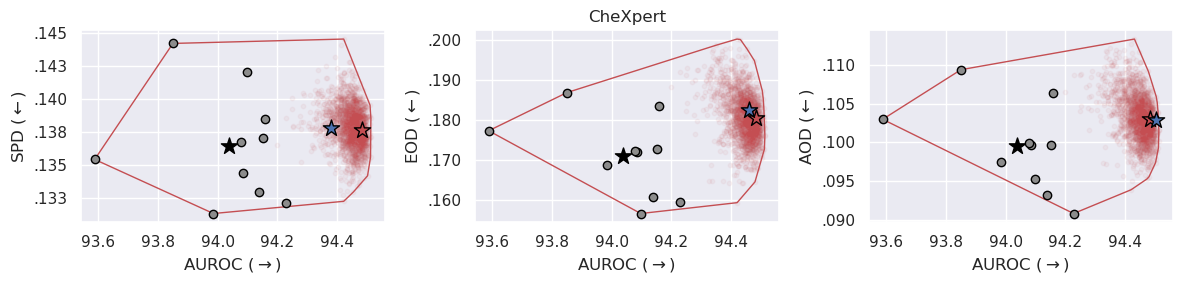

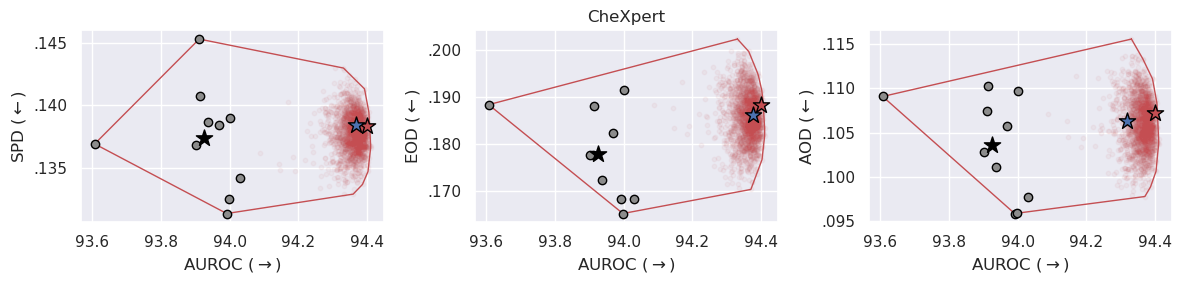

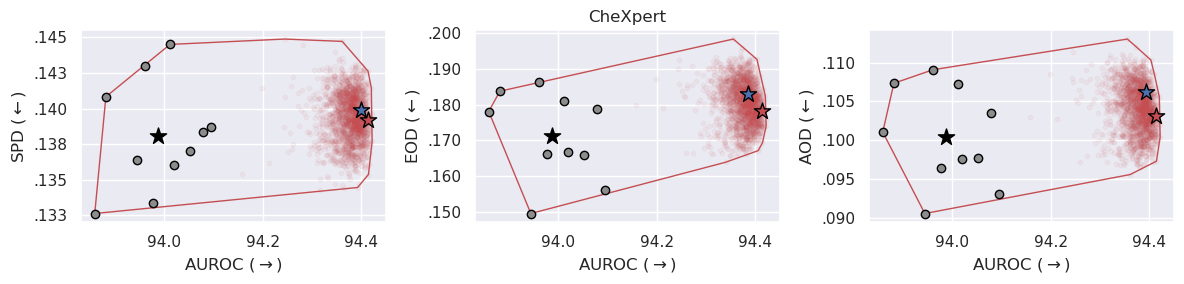

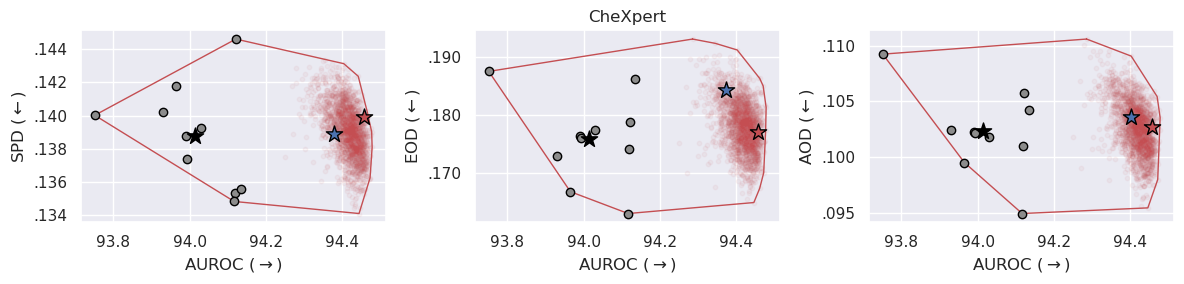

In [46]:
for m, mseed in enumerate(method_seeds):
    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].scatter(fair_aurocs[m], fair_spds[m], color="C7", edgecolors="black", zorder=99)
    axs[0].scatter(np.mean(fair_aurocs[m]), np.mean(fair_spds[m]), marker="*", c="black", s=150, zorder=99)
    axs[0].scatter(fair_m_aurocs[m], fair_m_spds[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[0].scatter(fair_rm_aurocs[m], fair_rm_spds[m], c="C3", s=10, alpha=0.05)
    axs[0].scatter(fair_rm_aurocs[m, spd_avg_rank_index[m]], fair_rm_spds[m, spd_avg_rank_index[m]], marker="*", c="C0", edgecolors="black", s=150, zorder=99)
    x_points, y_points = get_convex_hull_points(np.column_stack((fair_rm_aurocs[m].flatten(), fair_rm_spds[m].flatten())))
    axs[0].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[0].set_ylabel("SPD ($\\leftarrow$)")
    axs[1].scatter(fair_aurocs[m], fair_eods[m], color="C7", edgecolors="black", zorder=99)
    axs[1].scatter(np.mean(fair_aurocs[m]), np.mean(fair_eods[m]), marker="*", c="black", s=150, zorder=99)
    axs[1].scatter(fair_m_aurocs[m], fair_m_eods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[1].scatter(fair_rm_aurocs[m], fair_rm_eods[m], c="C3", s=10, alpha=0.05)
    axs[1].scatter(fair_rm_aurocs[m, eods_avg_rank_index[m]], fair_rm_eods[m, eods_avg_rank_index[m]], marker="*", c="C0", edgecolors="black", s=150, zorder=99)
    x_points, y_points = get_convex_hull_points(np.column_stack((fair_rm_aurocs[m].flatten(), fair_rm_eods[m].flatten())))
    axs[1].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[1].set_ylabel("EOD ($\\leftarrow$)")
    axs[2].scatter(fair_aurocs[m], fair_aods[m], color="C7", edgecolors="black", zorder=99)
    axs[2].scatter(np.mean(fair_aurocs[m]), np.mean(fair_aods[m]), marker="*", c="black", s=150, zorder=99)
    axs[2].scatter(fair_m_aurocs[m], fair_m_aods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[2].scatter(fair_rm_aurocs[m], fair_rm_aods[m], c="C3", s=10, alpha=0.05)
    axs[2].scatter(fair_rm_aurocs[m, aods_avg_rank_index[m]], fair_rm_aods[m, aods_avg_rank_index[m]], marker="*", c="C0", edgecolors="black", s=150, zorder=99)
    x_points, y_points = get_convex_hull_points(np.column_stack((fair_rm_aurocs[m].flatten(), fair_rm_aods[m].flatten())))
    axs[2].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[2].set_ylabel("AOD ($\\leftarrow$)")

    axs[1].set_title("CheXpert")

    for ax in axs.flatten():
        ax.set_xlabel("AUROC ($\\rightarrow$)")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))
    plt.tight_layout()
    plt.show()

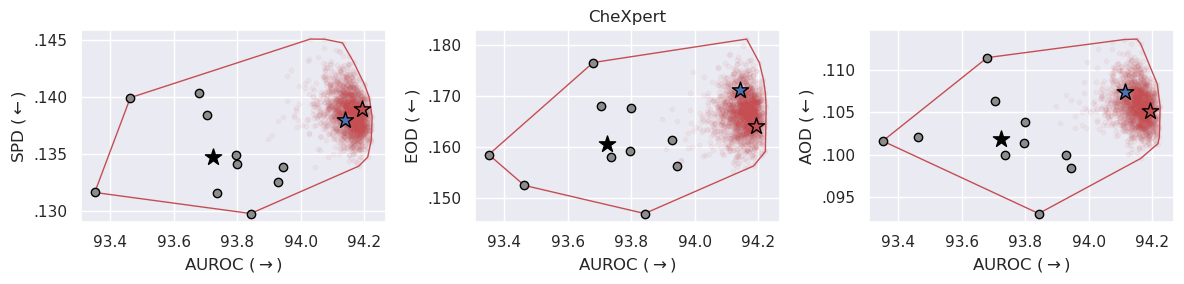

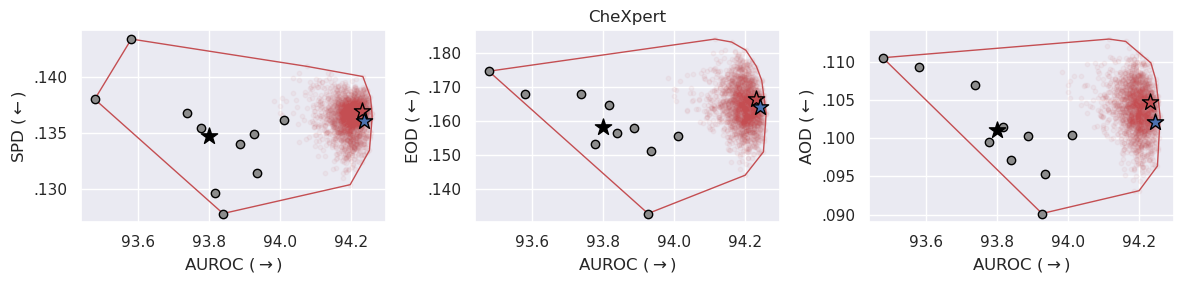

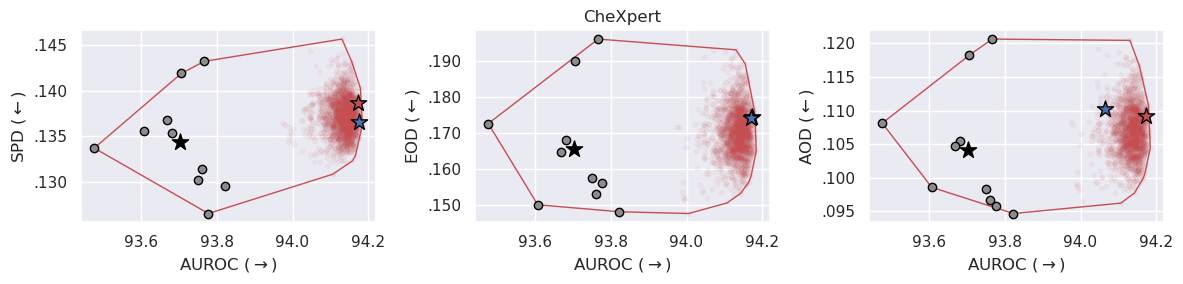

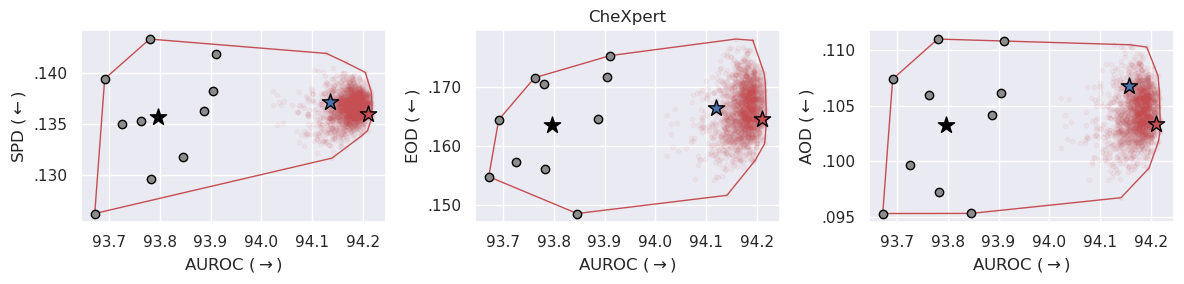

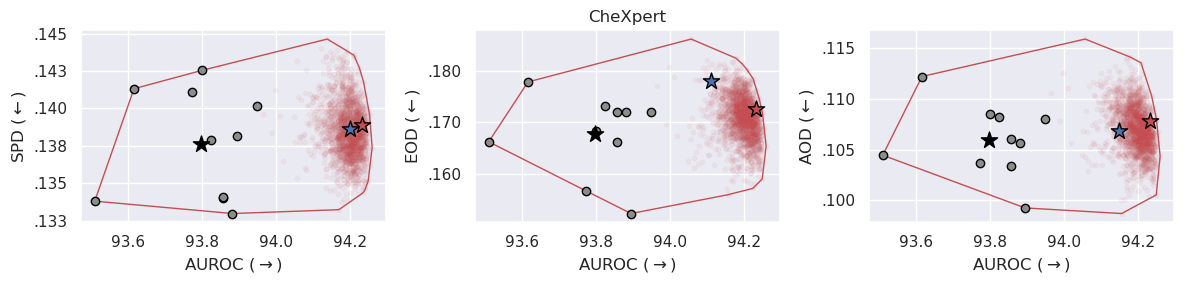

In [47]:
for m, mseed in enumerate(method_seeds):
    f, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].scatter(val_aurocs[m], val_spds[m], color="C7", edgecolors="black", zorder=99)
    axs[0].scatter(np.mean(val_aurocs[m]), np.mean(val_spds[m]), marker="*", c="black", s=150, zorder=99)
    axs[0].scatter(val_m_aurocs[m], val_m_spds[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[0].scatter(val_rm_aurocs[m], val_rm_spds[m], c="C3", s=10, alpha=0.05)
    axs[0].scatter(val_rm_aurocs[m, spd_avg_rank_index[m]], val_rm_spds[m, spd_avg_rank_index[m]], marker="*", c="C0", edgecolors="black", s=150, zorder=99)
    x_points, y_points = get_convex_hull_points(np.column_stack((val_rm_aurocs[m].flatten(), val_rm_spds[m].flatten())))
    axs[0].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[0].set_ylabel("SPD ($\\leftarrow$)")
    axs[1].scatter(val_aurocs[m], val_eods[m], color="C7", edgecolors="black", zorder=99)
    axs[1].scatter(np.mean(val_aurocs[m]), np.mean(val_eods[m]), marker="*", c="black", s=150, zorder=99)
    axs[1].scatter(val_m_aurocs[m], val_m_eods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[1].scatter(val_rm_aurocs[m], val_rm_eods[m], c="C3", s=10, alpha=0.05)
    axs[1].scatter(val_rm_aurocs[m, eods_avg_rank_index[m]], val_rm_eods[m, eods_avg_rank_index[m]], marker="*", c="C0", edgecolors="black", s=150, zorder=99)
    x_points, y_points = get_convex_hull_points(np.column_stack((val_rm_aurocs[m].flatten(), val_rm_eods[m].flatten())))
    axs[1].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[1].set_ylabel("EOD ($\\leftarrow$)")
    axs[2].scatter(val_aurocs[m], val_aods[m], color="C7", edgecolors="black", zorder=99)
    axs[2].scatter(np.mean(val_aurocs[m]), np.mean(val_aods[m]), marker="*", c="black", s=150, zorder=99)
    axs[2].scatter(val_m_aurocs[m], val_m_aods[m], marker="*", c="C3", edgecolors="black", s=150, zorder=99)
    axs[2].scatter(val_rm_aurocs[m], val_rm_aods[m], c="C3", s=10, alpha=0.05)
    axs[2].scatter(val_rm_aurocs[m, aods_avg_rank_index[m]], val_rm_aods[m, aods_avg_rank_index[m]], marker="*", c="C0", edgecolors="black", s=150, zorder=99)
    x_points, y_points = get_convex_hull_points(np.column_stack((val_rm_aurocs[m].flatten(), val_rm_aods[m].flatten())))
    axs[2].plot(x_points, y_points, '-', lw=1, c="C3")
    axs[2].set_ylabel("AOD ($\\leftarrow$)")

    axs[1].set_title("CheXpert")

    for ax in axs.flatten():
        ax.set_xlabel("AUROC ($\\rightarrow$)")
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.1f}"))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.3f}".lstrip("0")))
    plt.tight_layout()
    plt.show()